   status_id status_type status_published  num_reactions  num_comments  \
0          1       video   4/22/2018 6:00            529           512   
1          2       photo  4/21/2018 22:45            150             0   
2          3       video   4/21/2018 6:17            227           236   
3          4       photo   4/21/2018 2:29            111             0   
4          5       photo   4/18/2018 3:22            213             0   

   num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0         262        432         92         3          1         1   
1           0        150          0         0          0         0   
2          57        204         21         1          1         0   
3           0        111          0         0          0         0   
4           0        204          9         0          0         0   

   num_angrys  Column1  Column2  Column3  Column4  
0           0      NaN      NaN      NaN      NaN  
1           0      NaN      Na

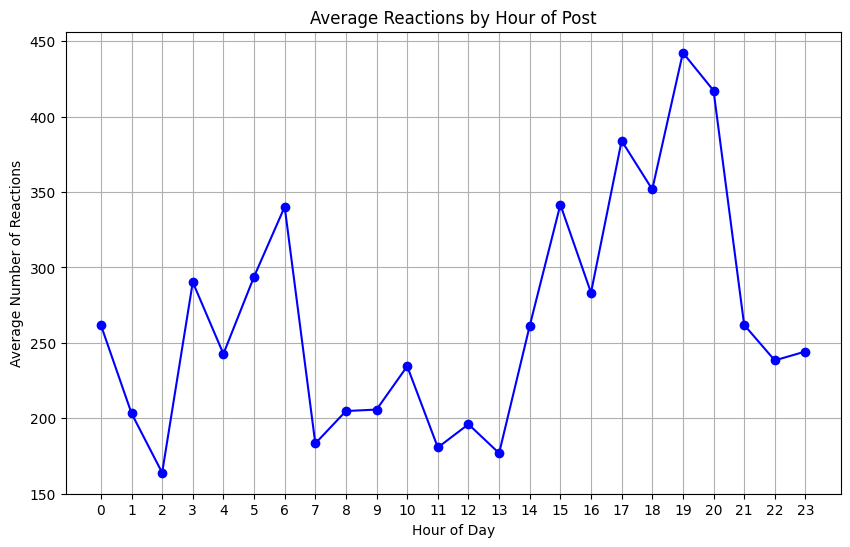

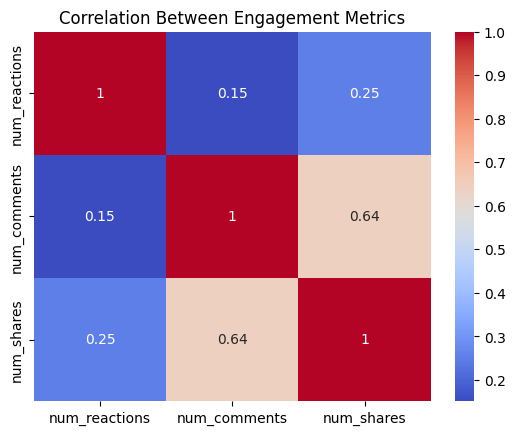

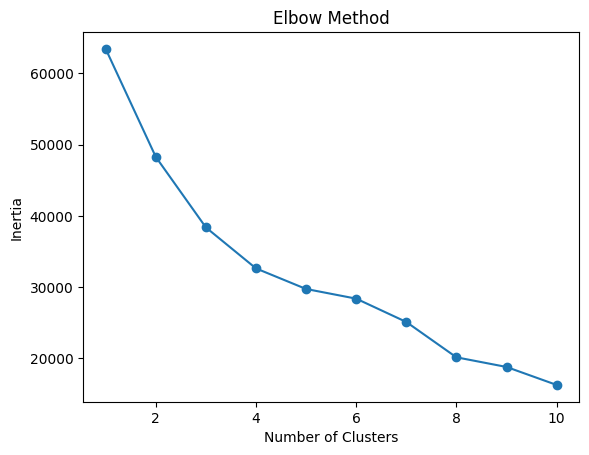

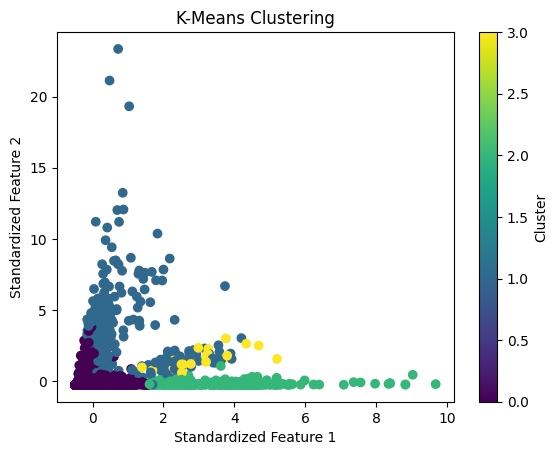

Post Type Counts:
status_type
photo     4288
video     2334
status     365
link        63
Name: count, dtype: int64


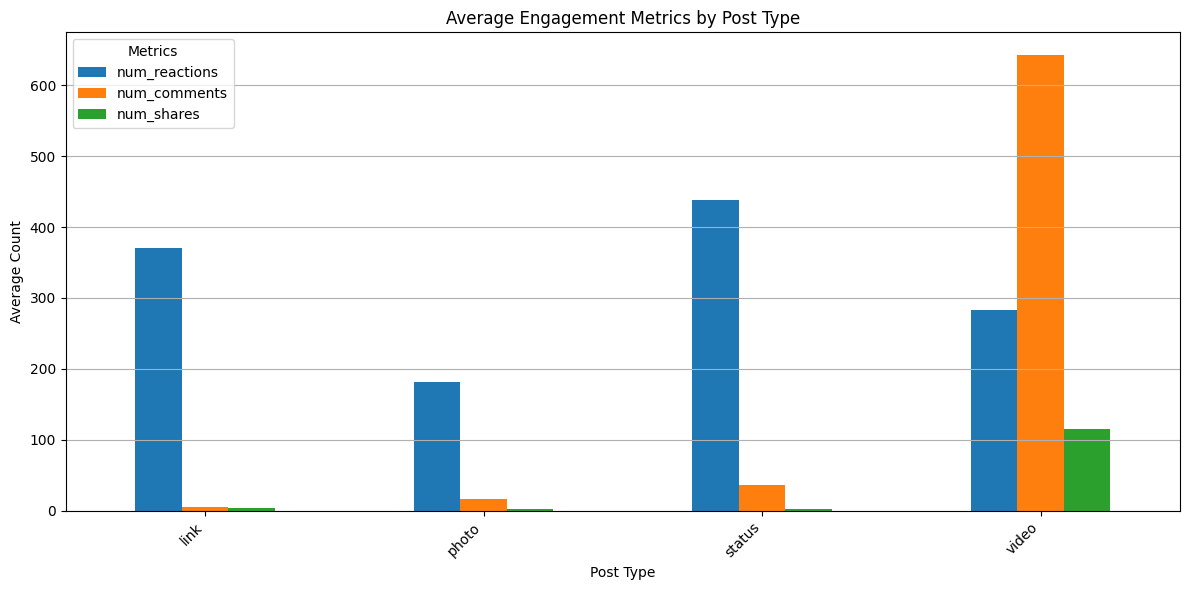

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

dataset_path = "Facebook_Marketplace_data.csv"
try:
    data = pd.read_csv(dataset_path)
except FileNotFoundError:
    raise FileNotFoundError(f"The file at {dataset_path} was not found. Please check the path.")

print(data.head())
data = data.fillna(0)
if data.empty:
    raise ValueError("Dataset is empty after handling missing values.")

data['status_published'] = pd.to_datetime(data['status_published'], errors='coerce')
data['hour'] = data['status_published'].dt.hour


hourly_reactions = data.groupby('hour')['num_reactions'].mean()
plt.figure(figsize=(10, 6))
plt.plot(hourly_reactions.index, hourly_reactions.values, marker='o', color='b', linestyle='-', markersize=6)
plt.title('Average Reactions by Hour of Post')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Reactions')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


correlation_matrix = data[['num_reactions', 'num_comments', 'num_shares']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Engagement Metrics')
plt.show()

features = ['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
X = data[features]

X = X.fillna(0)


if X.shape[0] == 0:
    raise ValueError("No valid data available for clustering after preprocessing.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)
data['cluster'] = kmeans.labels_

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=data['cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Standardized Feature 1')
plt.ylabel('Standardized Feature 2')
plt.colorbar(label='Cluster')
plt.show()

if 'status_type' in data.columns:
    post_counts = data['status_type'].value_counts()
    print("Post Type Counts:")
    print(post_counts)
else:
    print("'status_type' column not found in dataset.")

if 'status_type' in data.columns:
    avg_metrics = data.groupby('status_type')[['num_reactions', 'num_comments', 'num_shares']].mean()
    avg_metrics.plot(kind='bar', figsize=(12, 6))
    plt.title('Average Engagement Metrics by Post Type')
    plt.xlabel('Post Type')
    plt.ylabel('Average Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metrics')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("'status_type' column not found in dataset. Skipping post type analysis.")
data.to_csv("processed_facebook_data.csv", index=False)
